In [5]:
import numpy as np
import time as time
import matplotlib.pyplot as plt

# New code with changes

This is the new changed code. Here, we already include the energy spectrum, as it has to be calculated during the timesteps. Everything that has been added by us is marked as follows:
\####
\# explanation
\####

In [6]:
def WALE_LES(q, LES=True):

    # Domain
    lx, ly, lz = 2*np.pi, 2*np.pi, 2*np.pi

    # Grid
    nx, ny, nz = 2**q, 2**q, 2**q
    dx, dy, dz = lx/nx, ly/ny, lz/nz

    # Cell centers
    x = np.linspace(dx/2, lx - dx/2, nx)
    y = np.linspace(dy/2, ly - dy/2, ny)
    z = np.linspace(dz/2, lz - dz/2, nz)

    # Faces
    x_f = np.linspace(0,lx,nx+1)
    y_f = np.linspace(0,ly,ny+1)
    z_f = np.linspace(0,lz,nz+1)

    # Time step
    cfl = 0.15
    dt = cfl*dx
    lt = 20
    nt = round(lt/dt)

    # Reynolds number
    re = 1600

    ####
    # WALE coefficients
    ####
    Cw = 0.55
    Delta = (dx*dy*dz)**(1.0/3.0)

    # Initial velocity at cell centers
    u = np.zeros((nx,ny,nz))
    v = np.zeros((nx,ny,nz))
    w = np.zeros((nx,ny,nz))

    # The initial velocity is given by
    # u(x,y,z) = cos(x)*sin(y)*sin(z)
    # v(x,y,z) =-sin(x)*cos(y)*sin(z)
    # w(x,y,z) = 0.0
    # Cos and sin at cell centers
    cos = np.zeros(nx)
    sin = np.zeros(nx)
    for i in range(nx):
        cos[i] = np.cos(x[i])
        sin[i] = np.sin(x[i])
    # Initial velocity at cell centers
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                u[i,j,k] = cos[i]*sin[j]*sin[k]
                v[i,j,k] =-sin[i]*cos[j]*sin[k]
                w[i,j,k] = 0.0

    # Initialization of convective velocities
    u_convect = np.zeros((nx,ny,nz))
    v_convect = np.zeros((nx,ny,nz))
    w_convect = np.zeros((nx,ny,nz))

    # Initialization of fluxes
    fx = np.zeros((nx,ny,nz))
    fy = np.zeros((nx,ny,nz))
    fz = np.zeros((nx,ny,nz))

    # Initialization of pressure
    p = np.zeros((nx,ny,nz))

    # Initialization kinetic energy and dissipation
    e_kin = np.zeros((nt+1,2))
    dissp = np.zeros((nt  ,2))

    # Initialization WALE viscosity
    nu_t_cell = np.zeros((nx, ny, nz))

    # Cell-to-face interpolation

    def cell2face(f, ax):
        return (f + np.roll(f, 1, axis=ax))/2

    def meanx(f): return cell2face(f,0)
    def meany(f): return cell2face(f,1)
    def meanz(f): return cell2face(f,2)

    # Finite Differences

    def dfdx_face(f): return (f - np.roll(f, 1, axis=0))/dx
    def dfdy_face(f): return (f - np.roll(f, 1, axis=1))/dy
    def dfdz_face(f): return (f - np.roll(f, 1, axis=2))/dz

    def dfdx_cell(f): return (np.roll(f, -1, axis=0) - f)/dx
    def dfdy_cell(f): return (np.roll(f, -1, axis=1) - f)/dy
    def dfdz_cell(f): return (np.roll(f, -1, axis=2) - f)/dz

    ####
    # Central differences for the cell walls (midpoint of two velocities)
    ####

    def dfdx_central(f):
        return (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0))/(2*dx)
    def dfdy_central(f):
        return (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1))/(2*dy)
    def dfdz_central(f):
        return (np.roll(f, -1, axis=2) - np.roll(f, 1, axis=2))/(2*dz)

    ####
    # WALE viscosity calculation v_t
    ####
    def WALE_viscosity(u,v,w):

        # define partial derivatives
        dudx = dfdx_central(u)
        dudy = dfdy_central(u)
        dudz = dfdz_central(u)

        dvdx = dfdx_central(v)
        dvdy = dfdy_central(v)
        dvdz = dfdz_central(v)

        dwdx = dfdx_central(w)
        dwdy = dfdy_central(w)
        dwdz = dfdz_central(w)

        # velocity tensor g
        g11, g12, g13 = dudx, dudy, dudz
        g21, g22, g23 = dvdx, dvdy, dvdz
        g31, g32, g33 = dwdx, dwdy, dwdz

        # Strain-rate tensor S_ij
        S11 = dudx
        S22 = dvdy
        S33 = dwdz
        S12 = (dudy+dvdx)/2
        S13 = (dudz+dwdx)/2
        S23 = (dvdz+dwdy)/2

        S2 = S11**2+S22**2+S33**2+2*(S12**2+S13**2+S23**2)

        # compute g^2
        g2_11 = g11*g11 + g12*g21 + g13*g31
        g2_12 = g11*g12 + g12*g22 + g13*g32
        g2_13 = g11*g13 + g12*g23 + g13*g33
        g2_21 = g21*g11 + g22*g21 + g23*g31
        g2_22 = g21*g12 + g22*g22 + g23*g32
        g2_23 = g21*g13 + g22*g23 + g23*g33

        g2_31 = g31*g11 + g32*g21 + g33*g31
        g2_32 = g31*g12 + g32*g22 + g33*g32
        g2_33 = g31*g13 + g32*g23 + g33*g33

        # find trace of this g^2 for the computation of the entries of S^d
        g2_trace = g2_11 + g2_22 + g2_33

        # S^d as the traceless symmetric part of g^2
        Sd11 = g2_11 - 1/3*g2_trace
        Sd22 = g2_22 - 1/3*g2_trace
        Sd33 = g2_33 - 1/3*g2_trace
        Sd12 = (g2_12+g2_21)/2
        Sd13 = (g2_13+g2_31)/2
        Sd23 = (g2_23+g2_32)/2

        Sd2 = Sd11**2+Sd22**2+Sd33**2+2*(Sd12**2+Sd13**2+Sd23**2)

        # Combine to nu_t equation
        numerator = np.power(Sd2,1.5)
        denominator = np.power(S2,2.5)+np.power(Sd2,1.25)

        nu_t = (Cw*Delta)**2*numerator/denominator
        return np.maximum(nu_t,0)

    ####
    # Updated this function
    ####
    # Convective and viscous flux at faces
    def flux(u):

        # make new nu_eff=nu+nu_t
        nu_eff_x = 1/re + meanx(nu_t_cell)
        nu_eff_y = 1/re + meany(nu_t_cell)
        nu_eff_z = 1/re + meanz(nu_t_cell)

        # compute new fluxes
        fx = u_convect * meanx(u) - nu_eff_x * dfdx_face(u)
        fy = v_convect * meany(u) - nu_eff_y * dfdy_face(u)
        fz = w_convect * meanz(u) - nu_eff_z * dfdz_face(u)
        return fx, fy, fz

    # Face-normal velocity from cell-to-face interpolation

    def convect(u,v,w):
        u_convect = meanx(u)
        v_convect = meany(v)
        w_convect = meanz(w)
        return (u_convect,v_convect,w_convect)



    # Discrete divergence at cell center

    def divergence(fx,fy,fz):
        return ( dfdx_cell(fx) + dfdy_cell(fy) + dfdz_cell(fz) )



    # Incompressibility constraint

    # Wave numbers FFT (multiplied by 2*pi)
    kx = np.fft.fftfreq(nx, d=dx)*2*np.pi
    ky = np.fft.fftfreq(ny, d=dy)*2*np.pi
    kz = np.fft.fftfreq(nz, d=dz)*2*np.pi
    # Modified wave numbers for pressure Poisson equation
    km = np.zeros((nx, ny, nz))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                km[i,j,k] =            2*(np.cos(kx[i]*dx)-1)/(dx*dx)
                km[i,j,k] = km[i,j,k]+ 2*(np.cos(ky[j]*dy)-1)/(dy*dy)
                km[i,j,k] = km[i,j,k]+ 2*(np.cos(kz[k]*dz)-1)/(dz*dz)
    km[0,0,0] = 1  # avoid division by zero


    # FFT solver for pressure Poisson equation
    def pressure(div):
        p_hat = np.fft.fftn(div) / km
        p_hat[0, 0, 0] = 0  # zero mean pressure
        return np.real(np.fft.ifftn(p_hat))




    def energy(u,v,w):
        e_kin = 0.0
        for i in range(nx):
            for j in range(ny):
                for k in range(nz):
                    e_kin = e_kin + (u[i,j,k]**2) + (v[i,j,k]**2) + (w[i,j,k]**2)
        return e_kin/(2*nx*ny*nz)


    ####
    # Energy spectrum
    # Saved every two seconds
    ####
    def energy_spectrum_3d(u, v, w):
        nx, ny, nz = u.shape
        N = nx*ny*nz

        u0 = u - u.mean()
        v0 = v - v.mean()
        w0 = w - w.mean()

        U = np.fft.fftn(u0)
        V = np.fft.fftn(v0)
        W = np.fft.fftn(w0)

        kx_loc = 2*np.pi * np.fft.fftfreq(nx, d=dx)
        ky_loc = 2*np.pi * np.fft.fftfreq(ny, d=dy)
        kz_loc = 2*np.pi * np.fft.fftfreq(nz, d=dz)
        KX, KY, KZ = np.meshgrid(kx_loc, ky_loc, kz_loc, indexing="ij")
        kmag = np.sqrt(KX**2 + KY**2 + KZ**2)

        # Parseval-consistent for mean(u^2): mean(u^2) = (1/N^2) sum |U|^2
        E3d = 0.5*(np.abs(U)**2 + np.abs(V)**2 + np.abs(W)**2) / (N**2)

        kbin = np.rint(kmag).astype(int)
        kmax = kbin.max()
        Ek = np.bincount(kbin.ravel(), weights=E3d.ravel(), minlength=kmax+1)
        k = np.arange(len(Ek))
        return k, Ek

    spec_times = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]
    spec_done = {T: False for T in spec_times}


    # Time-stepping

    t = 0


    # Initial convective velocity
    u_convect,v_convect,w_convect = convect(u,v,w)
    ####
    # New nu_t for time stepping
    ####
    nu_t_cell[:] = WALE_viscosity(u,v,w)


    # Initial kinetic energy
    e_kin[0,0] = t
    e_kin[0,1] = energy(u,v,w)




    # Start of time-stepping
    start = time.time()


    for n in range(nt):



        ####
        # new updated WALE viscosity for each time step
        ####


        if LES:
            t0 = 7.0
            t_transistion = 3.0

            if t < t0:
                nu_t_cell[:] = 0.0
            elif t < t0 + t_transistion:
                alpha = (t - t0) / t_transistion
                nu_t_cell[:] = alpha * WALE_viscosity(u, v, w)
            elif t >= t0 + t_transistion:
                nu_t_cell[:] = WALE_viscosity(u, v, w)

            else:
                nu_t_cell[:] = 0.0

        # Tentative velocity

        fx,fy,fz = flux(u)
        u = u - dt*divergence(fx,fy,fz)

        fx,fy,fz = flux(v)
        v = v - dt*divergence(fx,fy,fz)

        fx,fy,fz = flux(w)
        w = w - dt*divergence(fx,fy,fz)


        # Tentative convective velocity
        u_convect, v_convect, w_convect = convect(u,v,w)


        # Solve pressure Poisson eq
        p = pressure(divergence(u_convect,v_convect,w_convect))


        # Add pressure gradient to face-normal velocity
        u_convect = u_convect - dfdx_face(p)
        v_convect = v_convect - dfdy_face(p)
        w_convect = w_convect - dfdz_face(p)


        # Update velocity at cell center
        u = u - dfdx_cell(meanx(p))
        v = v - dfdy_cell(meany(p))
        w = w - dfdz_cell(meanz(p))


        # Update time
        t = t + dt

        # Kinetic energy
        e_kin[n+1,0] = t
        e_kin[n+1,1] = energy(u,v,w)

        #print(t,e_kin[n+1,1])

        # Energy dissipation
        dissp[n,0] = t-0.5*dt
        dissp[n,1] = (e_kin[n,1]-e_kin[n+1,1])/dt

        # --- Save energy spectra
        for T in spec_times:
            if (not spec_done[T]) and (t >= T):
                k, Ek = energy_spectrum_3d(u, v, w)
                fname = f"spectrum_t{int(T):02d}_q{q}_{LES}.dat"
                np.savetxt(fname,
                           np.column_stack([k, Ek]))
                spec_done[T] = True


    duration = time.time() - start
    print(f"Time taken: {duration} seconds")

    np.savetxt(f'energyLESq{q}{LES}.dat',e_kin,fmt='%.12f')
    np.savetxt(f'dissipationLESq{q}{LES}.dat',dissp,fmt='%.12f')

    return e_kin, dissp, duration


This code is used to run the code for the desired grid sizes and whether we use LES/no LES

In [7]:
results_energy = {}
results_dissp = {}
results_time = {}

grids = [3,4,5,6,7]
Flags = [True,False]

for q in grids:
    for LES_flag in Flags:
        key = f"q{q}_LES{LES_flag}"
        print(f"Running {key} ...")
        e_kin, dissp, duration = WALE_LES(q, LES=LES_flag)
        results_energy[key] = e_kin
        results_dissp[key] = dissp
        results_time[key] = duration

Running q3_LESTrue ...
Time taken: 0.39497900009155273 seconds
Running q3_LESFalse ...
Time taken: 0.32120609283447266 seconds
Running q4_LESTrue ...
Time taken: 2.4839930534362793 seconds
Running q4_LESFalse ...
Time taken: 2.768735647201538 seconds


# Energy decay

This first code is used when the actual code is ran to plot the energy decay

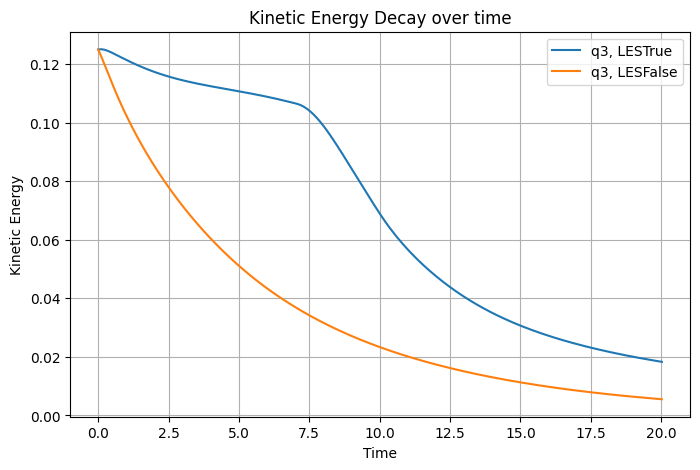

In [8]:
plt.figure(figsize=(8,5))
for key, e_kin in results_energy.items():
    #if "LESFalse" in key:
    #if "LESTrue" in key:
    if ("q3" in key or "q5" in key or "q7" in key):
        t = e_kin[:,0]
        E = e_kin[:,1]
        label = key.replace("_", ", ")
        plt.plot(t, E, label=label)
plt.xlabel("Time")
plt.ylabel("Kinetic Energy")
plt.title("Kinetic Energy Decay over time")
plt.grid(True)
plt.legend()
plt.show()

The second code is used when running with saved .dat files

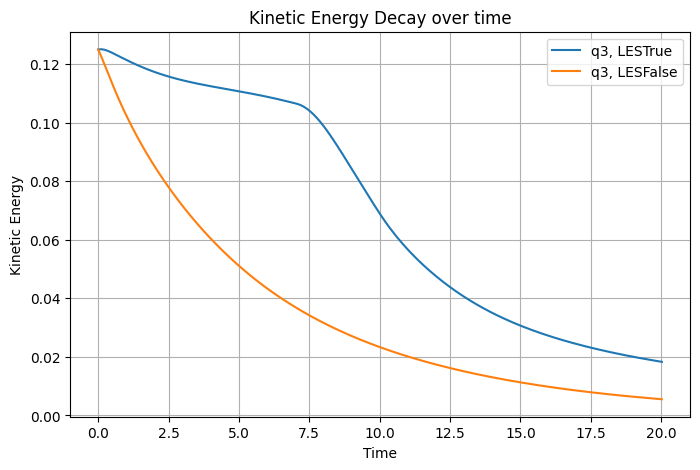

In [9]:
grids = [3,4,5,6,7]
Flags = [True,False]

results_energy = {}
# Load energy data
for q in grids:
    for LES_flag in Flags:
        key = f"q{q}_LES{LES_flag}"
        energy_les = np.loadtxt(f"energyLESq{q}{LES_flag}.dat")
        results_energy[key] = energy_les

# plot
plt.figure(figsize=(8,5))
for key, e_kin in results_energy.items():
    #if "LESFalse" in key:
    #if "LESTrue" in key:
    if ("q3" in key or "q5" in key or "q7" in key):
        t = e_kin[:,0]
        E = e_kin[:,1]
        label = key.replace("_", ", ")
        plt.plot(t, E, label=label)
plt.xlabel("Time")
plt.ylabel("Kinetic Energy")
plt.title("Kinetic Energy Decay over time")
plt.grid(True)
plt.legend()
plt.show()

# Dissipation rate

The same procedure is used for the dissipation rate.

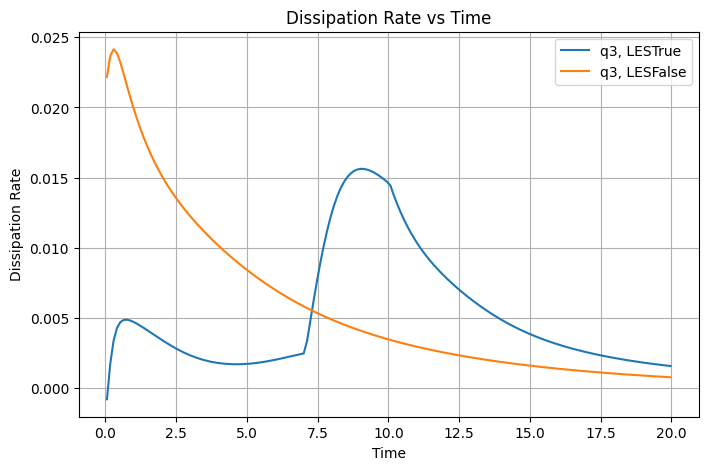

In [10]:
plt.figure(figsize=(8,5))
for key, dissp in results_dissp.items():
    #if "LESFalse" in key:
    #if "LESTrue" in key:
    if ("q3" in key or "q5" in key or "q7" in key):
        t = dissp[:,0]
        eps = dissp[:,1]
        label = key.replace("_", ", ")
        plt.plot(t, eps, label=label)
plt.xlabel("Time")
plt.ylabel("Dissipation Rate")
plt.title("Dissipation Rate vs Time")
plt.grid(True)
plt.legend()
plt.show()

Same with the .dat files

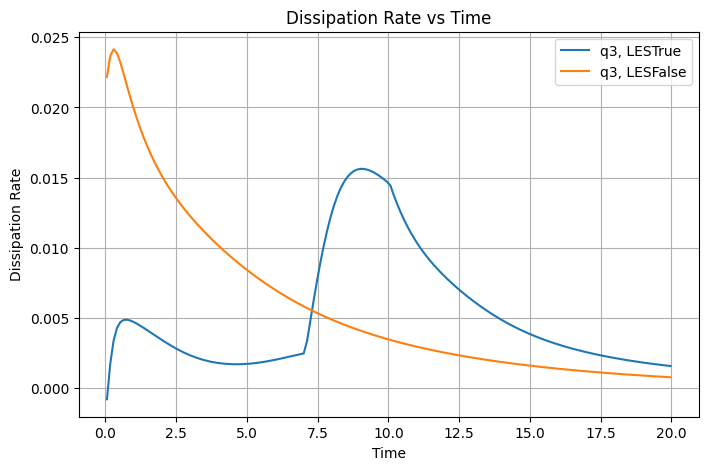

In [11]:
grids = [3,4,5,6,7]
Flags = [True,False]

results_dissp = {}
# Load dissp data
for q in grids:
    for LES_flag in Flags:
        key = f"q{q}_LES{LES_flag}"
        dissipation_les = np.loadtxt(f"dissipationLESq{q}{LES_flag}.dat")
        results_dissp[key] = dissipation_les

# plot
plt.figure(figsize=(8,5))
for key, dissp in results_dissp.items():
    #if "LESFalse" in key:
    #if "LESTrue" in key:
    if ("q3" in key or "q5" in key or "q7" in key):
        t = dissp[:,0]
        eps = dissp[:,1]
        label = key.replace("_", ", ")
        plt.plot(t, eps, label=label)
plt.xlabel("Time")
plt.ylabel("Dissipation Rate")
plt.title("Dissipation Rate vs Time")
plt.grid(True)
plt.legend()
plt.show()

# Time complexity

Here we can either make use of the given code, or we can make use of the list of our experimental research

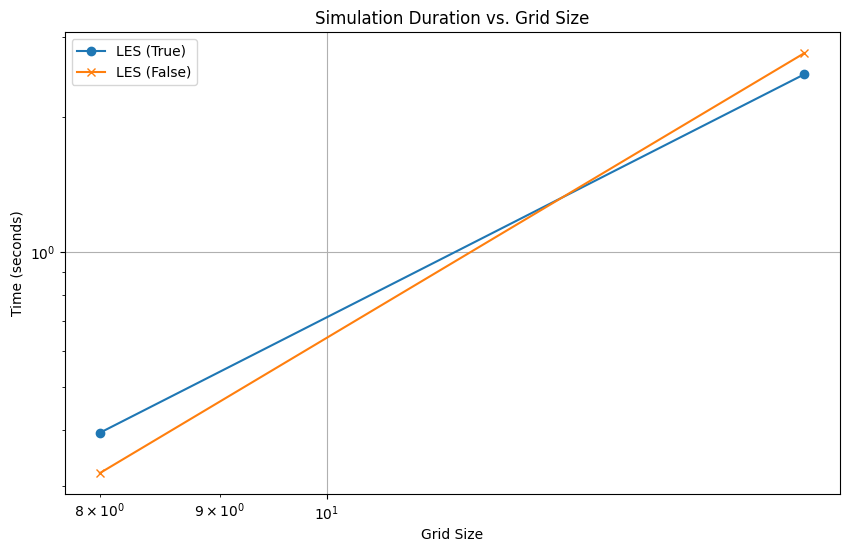

In [12]:
grid_sizes = [2**q for q in grids]

durations_les_true = [results_time[f'q{q}_LES{True}'] for q in grids]
durations_les_false = [results_time[f'q{q}_LES{False}'] for q in grids]

plt.figure(figsize=(10, 6))
plt.loglog(grid_sizes, durations_les_true, 'o-', label='LES (True)')
plt.loglog(grid_sizes, durations_les_false, 'x-', label='LES (False)')

plt.xlabel('Grid Size')
plt.ylabel('Time (seconds)')
plt.title('Simulation Duration vs. Grid Size')
plt.grid(True, ls="-")
plt.legend()
plt.show()

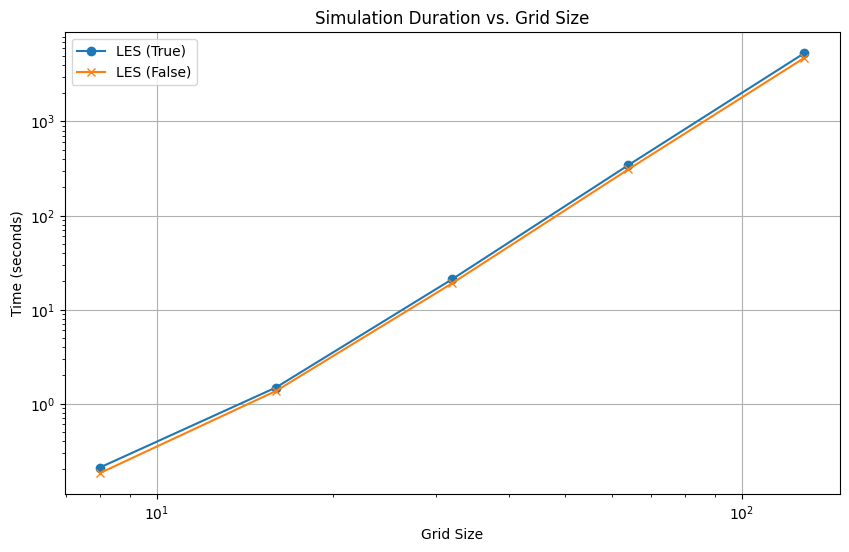

In [13]:
durations_les_true = [
    0.20908236503601074,   # q3
    1.4832768440246582,    # q4
    20.998364210128784,   # q5
    342.498343706131,     # q6
    5327.115653991699     # q7
]

# LES = False runtimes (seconds)
durations_les_false = [
    0.18238282203674316,  # q3
    1.3627028465270996,   # q4
    18.999953031539917,  # q5
    309.0016887187958,   # q6
    4740.700381994247    # q7
]

grid_sizes = [2**q for q in range(3,3+len(durations_les_false))]

plt.figure(figsize=(10, 6))
plt.loglog(grid_sizes, durations_les_true, 'o-', label='LES (True)')
plt.loglog(grid_sizes, durations_les_false, 'x-', label='LES (False)')

plt.xlabel('Grid Size')
plt.ylabel('Time (seconds)')
plt.title('Simulation Duration vs. Grid Size')
plt.grid(True, ls="-")
plt.legend()
plt.show()

# Accuracy over Time

We first want to find the errors ($L^2$, relative $L^2$ and $L^\infty$) which we store with its key. NOTE: This can only be run with the ReferenceSol.dat file loaded.

In [15]:
q = [3,4,5,6,7]
LES = [True, False]

L2_errors = {}
L2_relative_errors = {}
Linf_errors = {}

ref = np.loadtxt("RefereceSol.dat")
t_ref = ref[:, 0]
u_ref = ref[:, 1]
for q_val in q:
    for LES_flag in LES:
        key = f"q{q_val}_LES{LES_flag}"
        les = np.loadtxt(f"energyLESq{q_val}{LES_flag}.dat")
        t_les = les[:, 0]
        u_les = les[:, 1]

        u_ref_interp = np.interp(t_les, t_ref, u_ref)
        error = u_les - u_ref_interp
        L2_error = np.sqrt(np.mean(error**2))
        L2_relative_error = L2_error / np.sqrt(np.mean(u_ref_interp**2))

        L2_errors[key] = L2_error
        L2_relative_errors[key] = L2_relative_error
        Linf_errors[key] = np.max(np.abs(error))

We then make a list that sorts them all by their LES flag and $q$

In [16]:
import re

def split_by_flag(error_dict):
    q_true, e_true = [], []
    q_false, e_false = [], []

    for k, v in error_dict.items():
        q = int(re.search(r"q(\d+)", k).group(1))
        if "True" in k:
            q_true.append(q)
            e_true.append(v)
        else:
            q_false.append(q)
            e_false.append(v)

    # sort by q
    q_true, e_true = zip(*sorted(zip(q_true, e_true)))
    q_false, e_false = zip(*sorted(zip(q_false, e_false)))

    return q_true, e_true, q_false, e_false

Ultimately, we plot the desired quantity (grid size, duration) on the x-axis and the error on the y-axis

In [17]:
def plot_error(error_dict, ylabel, title):
    qT, eT, qF, eF = split_by_flag(error_dict)

    plt.loglog(qT, eT, 'o-', label='LES = True')
    plt.loglog(qF, eF, 's--', label='LES = False')

    plt.xlabel(r'Grid level $q$')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.tight_layout()
    plt.show()

This one is for the grid sizes

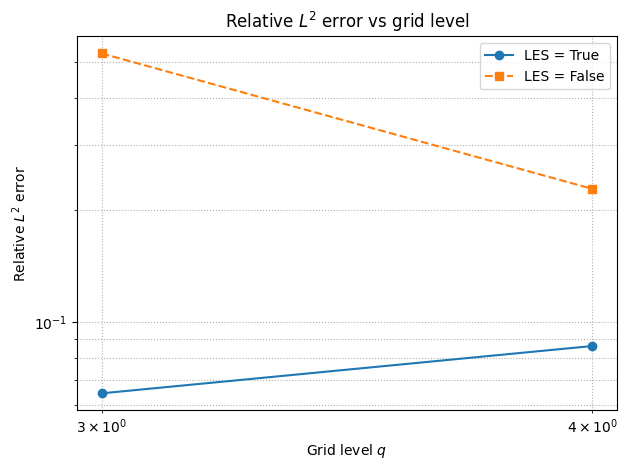

In [18]:
#plot_error(L2_errors, r'$L^2$ error', r'$L^2$ error vs grid level')
plot_error(L2_relative_errors, r'Relative $L^2$ error', r'Relative $L^2$ error vs grid level')
#plot_error(Linf_errors, r'$L^\infty$ error', r'$L^\infty$ error vs grid level')

This one is for the time duration

In [19]:
runtimes_dict = {}
for i, q_val in enumerate(q):
    runtimes_dict[f"q{q_val}_LESTrue"] = durations_les_true[i]
    runtimes_dict[f"q{q_val}_LESFalse"] = durations_les_false[i]

q_true_error, e_true_error, q_false_error, e_false_error = split_by_flag(L2_relative_errors)
#q_true_error, e_true_error, q_false_error, e_false_error = split_by_flag(L2_errors)
#q_true_error, e_true_error, q_false_error, e_false_error = split_by_flag(Linf_errors)
q_true_time, e_true_time, q_false_time, e_false_time = split_by_flag(runtimes_dict)

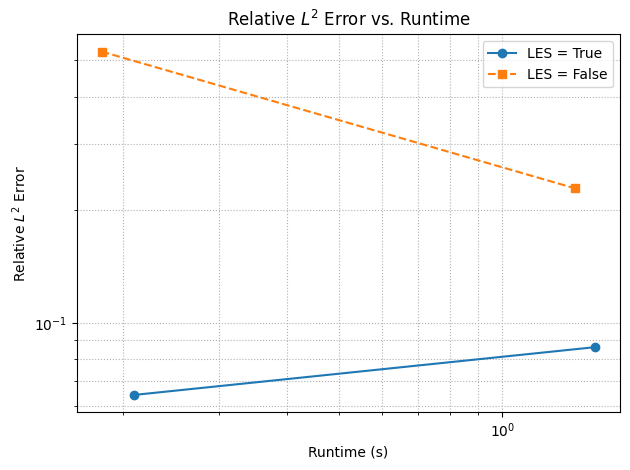

In [20]:
plt.loglog(e_true_time, e_true_error, 'o-', label='LES = True')

plt.loglog(e_false_time, e_false_error, 's--', label='LES = False')

plt.xlabel('Runtime (s)')
plt.ylabel('Relative $L^2$ Error')
plt.title('Relative $L^2$ Error vs. Runtime')
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# Energy spectra plots

For these we can only make use of the saved plots

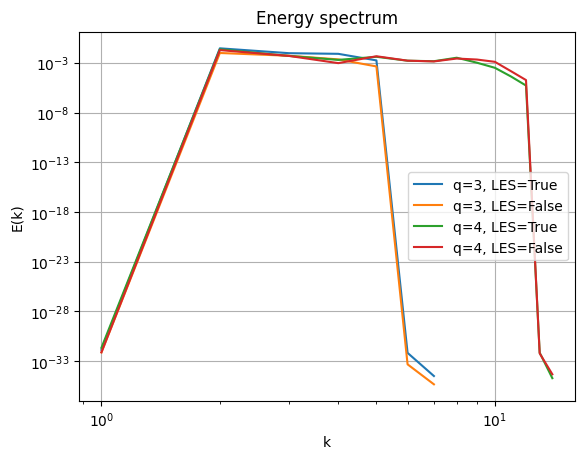

In [21]:
grids = [3,4,5,6,7]
Flags = [True,False]

for q in grids:
    for LES_flag in Flags:
        k, Ek = np.loadtxt(f"spectrum_t{int(12):02d}_q{q}_{LES_flag}.dat", unpack=True)
        plt.loglog(k[2:], Ek[2:], label=f"q={q}, LES={LES_flag}") # skip k=0
plt.xlabel("k")
plt.ylabel("E(k)")
#plt.ylim(1e-7,1e-1)
plt.title("Energy spectrum")
plt.grid(True)
plt.legend()
plt.show()